# Description of the project
"""
In this project, we are working with the "Smart Meters in London" dataset to predict power consumption.
The goal is to forecast future power usage based on the data provided by smart meters.

Data Source: https://www.kaggle.com/datasets/jeanmidev/smart-meters-in-london

Steps taken:
1. **Data Preprocessing**:
   - Loaded the dataset and handled missing values by dropping rows with NaN values.
   - Separated features (X) and target (y) from the dataset, where 'energy_sum' is the column to predict.

2. **Feature Scaling**:
   - Scaled the features using StandardScaler to standardize the data, ensuring that the model works efficiently with features on different scales.

3. **Model Building**:
   - Built a **Neural Network (NN)** model using TensorFlow/Keras with two hidden layers and dropout to prevent overfitting.
   - The model is compiled with the Adam optimizer and mean squared error (MSE) loss.

4. **Training and Evaluation**:
   - The NN model was trained on the training data for 100 epochs, with a batch size of 32 and a validation split of 20%.
   - The performance of the NN model was evaluated using MSE, MAE (mean absolute error), and R2 score.

5. **Alternative Models**:
   - Compared the performance of the NN model with other machine learning models:
     - **Linear Regression**
     - **Support Vector Regressor (SVR)**
     - **Random Forest Regressor**

   - Each model was evaluated using the same metrics (MSE, MAE, R2) to determine the best-performing model.

6. **Visualization**:
   - A bar plot was created to compare the MSE scores of all models, providing a clear visual representation of their performance.

Next steps involve fine-tuning the best-performing model and applying it to real-world data for prediction.
"""

### Data Preparation: Merging Datasets Using XLOOKUP in Excel

To prepare the data for analysis, I merged information from multiple sources using the **XLOOKUP** function in Excel. This involved combining data from `weather.csv`, `daily_dataset.csv`, and `informations_households.csv` into a unified dataset.

#### Steps:
1. **Merging Weather Data**:
   - Opened `weather.csv` and `daily_dataset.csv` in Excel.
   - Identified the common column (e.g., `Date`) as the lookup key.
   - Used the **XLOOKUP** formula to retrieve the following columns from `weather.csv`:
     - **`humidity`**
     - **`tempmax`**
     - **`tempmin`**
     - **`pressure`**
   - Formula used:
     ```
     =XLOOKUP(lookup_value, lookup_array, return_array, [if_not_found])
     ```
     - **lookup_value**: The key column value in `daily_dataset.csv` (e.g., `Date`).
     - **lookup_array**: The corresponding key column in `weather.csv`.
     - **return_array**: The column(s) to retrieve from `weather.csv`.
     - **[if_not_found]**: A value or message if no match is found (e.g., `"Not Found"`).

2. **Adding Household Information**:
   - Opened `informations_households.csv` and `daily_dataset.csv`.
   - Used the **XLOOKUP** function to retrieve the `Acron` column from `informations_households.csv`, based on the common key (e.g., `Household_ID` or another identifier).
   - Verified that all matches were correctly aligned.

3. **Final Dataset**:
   - Combined `daily_dataset.csv` with the extracted columns (`humidity`, `tempmax`, `tempmin`, `pressure`, and `Acron`).
   - Saved the enriched dataset as a new CSV file for further processing in Python.

This process ensured that the final dataset contained all the necessary weather and household information, enabling more comprehensive analysis and modeling.




In [34]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/daily_dataset.csv')

In [36]:
df.head()

,Unnamed: 0,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,humidity,acron,tempmax,tempmin,pressure
0,MAC000131,12/15/2011,0.4850,0.432045,0.868,22,0.239146,9.505,0.072,0.77,ACORN-E,7.97,4.08,996.75
1,MAC000131,12/16/2011,0.1415,0.296167,1.116,48,0.281471,14.216,0.031,0.88,ACORN-E,4.68,1.80,988.10
2,MAC000131,12/17/2011,0.1015,0.189812,0.685,48,0.188405,9.111,0.064,0.86,ACORN-E,5.35,0.24,1008.46
3,MAC000131,12/18/2011,0.1140,0.218979,0.676,48,0.202919,10.511,0.065,0.84,ACORN-E,5.49,-0.56,1016.37
4,MAC000131,12/19/2011,0.1910,0.325979,0.788,48,0.259205,15.647,0.066,0.94,ACORN-E,6.64,-0.84,1014.39


In [37]:
df.columns

Index(['Unnamed: 0', 'day', 'energy_median', 'energy_mean', 'energy_max',
       'energy_count', 'energy_std', 'energy_sum', 'energy_min', 'humidity',
       'acron', 'tempmax', 'tempmin', 'pressure'],
      dtype='object')

In [38]:
df_ready = df.drop(columns=['Unnamed: 0', 'day']).copy()

In [39]:
df_ready.columns

Index(['energy_median', 'energy_mean', 'energy_max', 'energy_count',
       'energy_std', 'energy_sum', 'energy_min', 'humidity', 'acron',
       'tempmax', 'tempmin', 'pressure'],
      dtype='object')

In [40]:
df_ready.head()

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,humidity,acron,tempmax,tempmin,pressure
0,0.4850,0.432045,0.868,22,0.239146,9.505,0.072,0.77,ACORN-E,7.97,4.08,996.75
1,0.1415,0.296167,1.116,48,0.281471,14.216,0.031,0.88,ACORN-E,4.68,1.80,988.10
2,0.1015,0.189812,0.685,48,0.188405,9.111,0.064,0.86,ACORN-E,5.35,0.24,1008.46
3,0.1140,0.218979,0.676,48,0.202919,10.511,0.065,0.84,ACORN-E,5.49,-0.56,1016.37
4,0.1910,0.325979,0.788,48,0.259205,15.647,0.066,0.94,ACORN-E,6.64,-0.84,1014.39


In [41]:
len(df_ready.acron.unique())

13

In [42]:
df_ready.acron.unique()

array(['ACORN-E', 'ACORN-N', 'ACORN-H', 'ACORN-P', 'ACORN-F', 'ACORN-K',
       'ACORN-Q', 'ACORN-I', 'ACORN-L', 'ACORN-D', 'ACORN-J', 'ACORN-U',
       'ACORN-O'], dtype=object)

In [43]:
df_one_hot = pd.get_dummies(df['acron'], prefix='ACORN')
df_ready = pd.concat([df_ready, df_one_hot], axis=1)

In [44]:
df_ready.head()

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,humidity,acron,tempmax,...,ACORN_ACORN-H,ACORN_ACORN-I,ACORN_ACORN-J,ACORN_ACORN-K,ACORN_ACORN-L,ACORN_ACORN-N,ACORN_ACORN-O,ACORN_ACORN-P,ACORN_ACORN-Q,ACORN_ACORN-U
0,0.4850,0.432045,0.868,22,0.239146,9.505,0.072,0.77,ACORN-E,7.97,...,False,False,False,False,False,False,False,False,False,False
1,0.1415,0.296167,1.116,48,0.281471,14.216,0.031,0.88,ACORN-E,4.68,...,False,False,False,False,False,False,False,False,False,False
2,0.1015,0.189812,0.685,48,0.188405,9.111,0.064,0.86,ACORN-E,5.35,...,False,False,False,False,False,False,False,False,False,False
3,0.1140,0.218979,0.676,48,0.202919,10.511,0.065,0.84,ACORN-E,5.49,...,False,False,False,False,False,False,False,False,False,False
4,0.1910,0.325979,0.788,48,0.259205,15.647,0.066,0.94,ACORN-E,6.64,...,False,False,False,False,False,False,False,False,False,False


In [45]:
df_ready.loc[0]

,0
energy_median,0.485
energy_mean,0.432045
energy_max,0.868
energy_count,22
energy_std,0.239146
energy_sum,9.505
energy_min,0.072
humidity,0.77
acron,ACORN-E
tempmax,7.97


In [46]:
df_ready.drop(columns=['acron'],inplace = True)

In [47]:
df_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 24 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   energy_median  1048565 non-null  float64
 1   energy_mean    1048565 non-null  float64
 2   energy_max     1048565 non-null  float64
 3   energy_count   1048575 non-null  int64  
 4   energy_std     1045193 non-null  float64
 5   energy_sum     1048565 non-null  float64
 6   energy_min     1048565 non-null  float64
 7   humidity       458710 non-null   float64
 8   tempmax        458710 non-null   float64
 9   tempmin        458710 non-null   float64
 10  pressure       458710 non-null   float64
 11  ACORN_ACORN-D  1048575 non-null  bool   
 12  ACORN_ACORN-E  1048575 non-null  bool   
 13  ACORN_ACORN-F  1048575 non-null  bool   
 14  ACORN_ACORN-H  1048575 non-null  bool   
 15  ACORN_ACORN-I  1048575 non-null  bool   
 16  ACORN_ACORN-J  1048575 non-null  bool   
 17  ACORN_AC

In [48]:
df_ready.dropna(inplace=True)

In [49]:
X = df_ready.drop(columns=['energy_sum'], axis=1 )
y = df_ready['energy_sum']

In [50]:
df_ready.isnull().sum()

,0
energy_median,0
energy_mean,0
energy_max,0
energy_count,0
energy_std,0
energy_sum,0
energy_min,0
humidity,0
tempmax,0
tempmin,0


In [51]:
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [53]:
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1], kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [54]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
9131/9131 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 19.4240 - mae: 2.5255 - val_loss: 1.9468 - val_mae: 0.6384
Epoch 2/100
9131/9131 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 8.6002 - mae: 1.7082 - val_loss: 2.2960 - val_mae: 0.5721
Epoch 3/100
9131/9131 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 7.4698 - mae: 1.5398 - val_loss: 2.6319 - val_mae: 0.4432
Epoch 4/100
9131/9131 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - loss: 6.6277 - mae: 1.4803 - val_loss: 2.0589 - val_mae: 0.3735
Epoch 5/100
9131/9131 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 6.3418 - mae: 1.4438 - val_loss: 1.7964 - val_mae: 0.4640
Epoch 6/100
9131/9131 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - loss: 6.2365 - mae: 1.4210 - val_loss: 1.2571 - val_mae: 0.4062
Epoch 7/100
9131/9131 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 6.1379 - mae: 1.4210 - val_loss: 3.0503 - val_mae: 0.5512
Epoch 8/100
9131/9131 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - loss: 6.0411 - mae: 1.4024 - val_loss: 2.0309 - val_mae: 0.5383
Epoch 9/100
9131/9131 ━

In [55]:
# Predict with the neural network model
y_pred_nn = model.predict(X_test)

# Calculate metrics
mse_loss = mean_squared_error(y_test, y_pred_nn)
mae_loss = mean_absolute_error(y_test, y_pred_nn)
r2 = r2_score(y_test, y_pred_nn)

# Print the results
print("Neural Network Metrics:")
print("Loss (MSE):", mse_loss)
print("MAE:", mae_loss)
print("R2 Score:", r2)

2854/2854 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Neural Network Metrics:
Loss (MSE): 0.4308012044120059
MAE: 0.4058229796517729
R2 Score: 0.9962569678288246


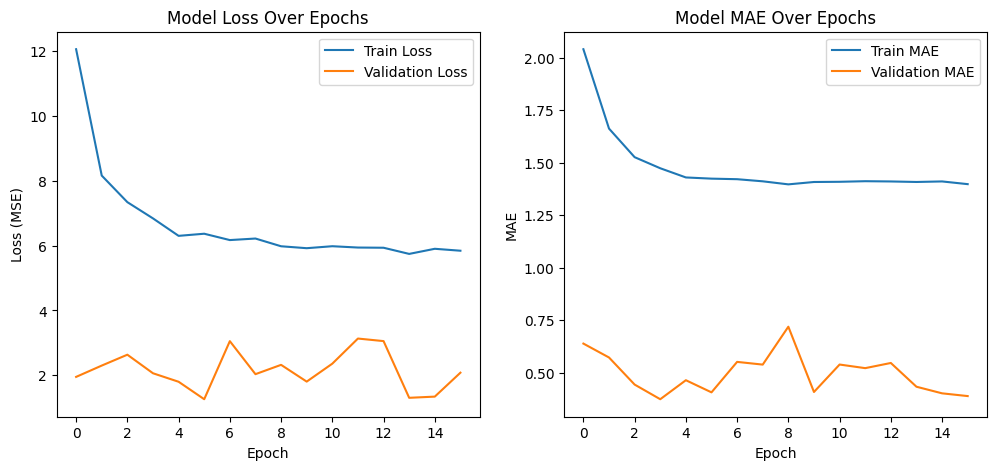

In [56]:
# Plot training & validation loss values
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()


2854/2854 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


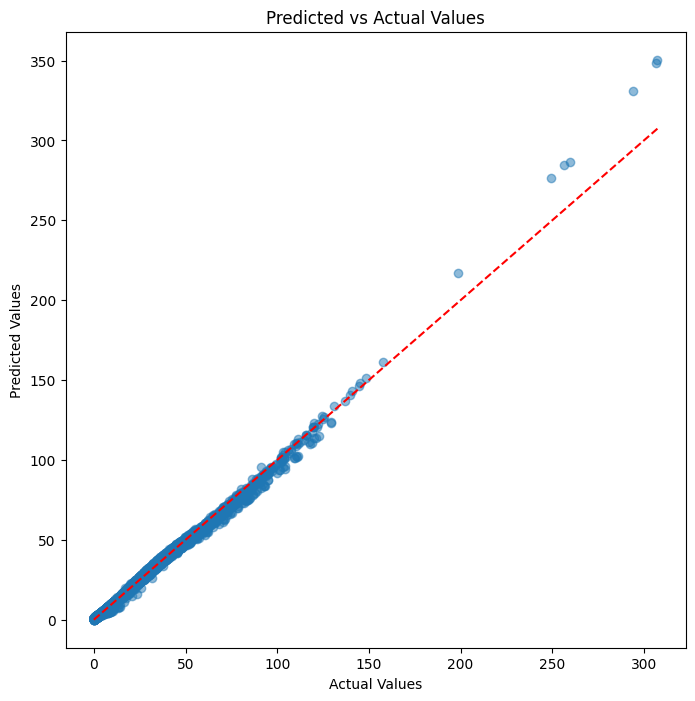

In [57]:
# Make predictions
y_pred = model.predict(X_test)

# Plot predictions vs. actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Perfect prediction line
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [58]:
# Alternative Models for Comparison
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, random_state=42)
}

In [59]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Metrics:")
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("R2 Score:", r2_score(y_test, y_pred))


Linear Regression Metrics:
MSE: 0.044668280588180155
MAE: 0.011066602635292059
R2 Score: 0.9996118979948052

Random Forest Regressor Metrics:
MSE: 0.03596973110760419
MAE: 0.003798846737402223
R2 Score: 0.9996874756631471


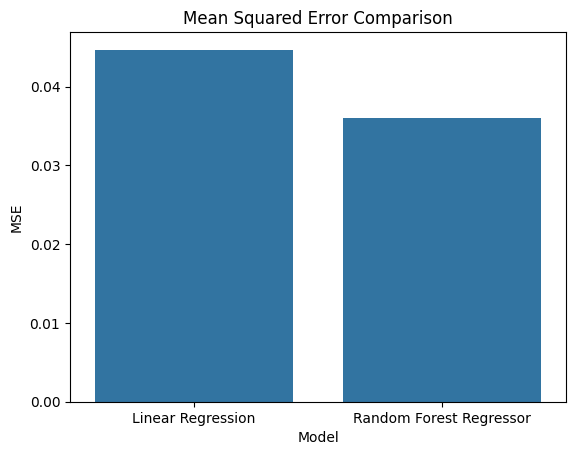

In [60]:
# Visualization of Model Performance
errors = {
    "Model": [],
    "MSE": [],
    "MAE": [],
    "R2 Score": []
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    errors["Model"].append(name)
    errors["MSE"].append(mean_squared_error(y_test, y_pred))
    errors["MAE"].append(mean_absolute_error(y_test, y_pred))
    errors["R2 Score"].append(r2_score(y_test, y_pred))

errors_df = pd.DataFrame(errors)
sns.barplot(x='Model', y='MSE', data=errors_df)
plt.title('Mean Squared Error Comparison')
plt.show()